<a href="https://colab.research.google.com/github/srijabiswas-01/reinforcement-learning-trading-bot/blob/main/stock-ananlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Elite Reinforcement Learning–Based Automated Trading Agent

This notebook demonstrates the initial data analysis and environment setup
for a reinforcement learning–based stock trading agent.


In [1]:
!pip install -q yfinance pandas numpy plotly ta scipy stable-baselines3 gymnasium seaborn matplotlib

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

### **Market ETFs (tradable proxies)**

In [3]:
markets = {
    "USA_S&P500": "SPY",
    "Australia_ASX200": "STW.AX",
    "UK_FTSE100": "ISF.L",
    "Japan_Nikkei225": "EWJ",
    "China_SSE": "FXI",
    "India_NIFTY50": "NIFTYBEES.NS"
}

start_date = "2015-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

market_data = {}

### **Data Download & Cleaning**

In [4]:
for market_name, ticker in markets.items():

    print(f"\nDownloading {market_name} ({ticker}) ...")

    df = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        interval="1d",
        auto_adjust=False,
        progress=False
    )

    # Fix Yahoo MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None

    # Drop invalid rows
    df.dropna(subset=["Close"], inplace=True)

    # Date column
    df.reset_index(inplace=True)

    # Standard OHLCV
    df = df[[
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "Adj Close",
        "Volume"
    ]]

    df.sort_values("Date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    market_data[market_name] = df

    print(f"✔ Rows: {len(df)} | Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")


✔ Rows: 2790 | Date range: 2015-01-02 → 2026-02-05

✔ Rows: 2808 | Date range: 2015-01-02 → 2026-02-05

✔ Rows: 2803 | Date range: 2015-01-02 → 2026-02-05

✔ Rows: 2790 | Date range: 2015-01-02 → 2026-02-05

✔ Rows: 2790 | Date range: 2015-01-02 → 2026-02-05

✔ Rows: 2741 | Date range: 2015-01-01 → 2026-02-05


In [5]:
market_data["USA_S&P500"].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,206.380005,206.880005,204.179993,205.429993,170.589615,121465900
1,2015-01-05,204.169998,204.369995,201.350006,201.720001,167.508835,169632600
2,2015-01-06,202.089996,202.720001,198.860001,199.820007,165.931076,209151400
3,2015-01-07,201.419998,202.720001,200.880005,202.309998,167.998734,125346700
4,2015-01-08,204.009995,206.160004,203.990005,205.899994,170.979843,147217800


In [6]:
for market, df in market_data.items():
    print(f"\n{market}")
    print("Start date :", df.index.min())
    print("End date   :", df.index.max())
    print("Rows       :", len(df))
    print("Columns    :", df.columns.tolist())


USA_S&P500
Start date : 0
End date   : 2789
Rows       : 2790
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

Australia_ASX200
Start date : 0
End date   : 2807
Rows       : 2808
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

UK_FTSE100
Start date : 0
End date   : 2802
Rows       : 2803
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

Japan_Nikkei225
Start date : 0
End date   : 2789
Rows       : 2790
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

China_SSE
Start date : 0
End date   : 2789
Rows       : 2790
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

India_NIFTY50
Start date : 0
End date   : 2740
Rows       : 2741
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [7]:
clean_market_data = {}

for market, df in market_data.items():

    # Reset index so Date becomes a column
    df = df.reset_index()

    # Ensure clean single-level columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Standardise column order
    df = df[[
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume"
    ]]

    clean_market_data[market] = df

    print(f"{market} cleaned successfully → Shape: {df.shape}")


USA_S&P500 cleaned successfully → Shape: (2790, 6)
Australia_ASX200 cleaned successfully → Shape: (2808, 6)
UK_FTSE100 cleaned successfully → Shape: (2803, 6)
Japan_Nikkei225 cleaned successfully → Shape: (2790, 6)
China_SSE cleaned successfully → Shape: (2790, 6)
India_NIFTY50 cleaned successfully → Shape: (2741, 6)


In [8]:
for market, df in clean_market_data.items():
    print("\n" + "=" * 60)
    print(f"Market: {market}")
    print("Column Headers:")
    print(df.columns.tolist())
    print("\nFirst 5 rows:")
    print(df.head(5))


Market: USA_S&P500
Column Headers:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

First 5 rows:
        Date        Open        High         Low       Close     Volume
0 2015-01-02  206.380005  206.880005  204.179993  205.429993  121465900
1 2015-01-05  204.169998  204.369995  201.350006  201.720001  169632600
2 2015-01-06  202.089996  202.720001  198.860001  199.820007  209151400
3 2015-01-07  201.419998  202.720001  200.880005  202.309998  125346700
4 2015-01-08  204.009995  206.160004  203.990005  205.899994  147217800

Market: Australia_ASX200
Column Headers:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

First 5 rows:
        Date       Open       High        Low      Close  Volume
0 2015-01-02  50.029999  50.400002  50.029999  50.400002   84844
1 2015-01-05  50.689999  50.730000  50.320000  50.650002   42645
2 2015-01-06  50.180000  50.180000  49.459999  49.770000  232437
3 2015-01-07  49.880001  49.880001  49.299999  49.630001   58253
4 2015-01-08  49.900002  50.04999

### **Feature Engineering (RL-relevant)**

In [9]:
for market, df in market_data.items():

    # Returns (adjusted close)
    df["Return"] = df["Adj Close"].pct_change()

    # Rolling volatility
    df["Volatility_20"] = df["Return"].rolling(20).std()

    # Momentum
    df["Momentum_10"] = df["Adj Close"] / df["Adj Close"].shift(10) - 1

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    market_data[market] = df

    print(f"{market} → Features added | Shape: {df.shape}")

USA_S&P500 → Features added | Shape: (2770, 10)
Australia_ASX200 → Features added | Shape: (2788, 10)
UK_FTSE100 → Features added | Shape: (2783, 10)
Japan_Nikkei225 → Features added | Shape: (2770, 10)
China_SSE → Features added | Shape: (2770, 10)
India_NIFTY50 → Features added | Shape: (2721, 10)


In [10]:
for market, df in market_data.items():
    print("\n" + "=" * 60)
    print(f"Market: {market}")
    print("Column Headers:")
    print(df.columns.tolist())
    print("\nFirst 5 rows:")
    print(df.head(5))


Market: USA_S&P500
Column Headers:
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Return', 'Volatility_20', 'Momentum_10']

First 5 rows:
        Date        Open        High         Low       Close   Adj Close  \
0 2015-02-02  200.050003  202.029999  197.860001  201.919998  167.674942   
1 2015-02-03  203.000000  204.850006  202.550003  204.839996  170.099655   
2 2015-02-04  203.919998  205.380005  203.509995  204.059998  169.451950   
3 2015-02-05  204.860001  206.300003  204.770004  206.119995  171.162643   
4 2015-02-06  206.559998  207.240005  204.919998  205.550003  170.689285   

      Volume    Return  Volatility_20  Momentum_10  
0  163107000  0.012384       0.011050     0.001438  
1  124212900  0.014461       0.010766     0.013758  
2  134306700 -0.003808       0.010557     0.004826  
3   97953200  0.010095       0.010435     0.000097  
4  125672000 -0.002766       0.009682     0.002830  

Market: Australia_ASX200
Column Headers:
['Date', 'Open', 'High', '

In [11]:
clean_market_data = {}

for market, df in market_data.items():
    clean_market_data[market] = df[[
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Return",
        "Volatility_20",
        "Momentum_10"
    ]]

### **EXPLORATORY DATA ANALYSIS (EDA)**

Summary Statistics

In [21]:
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")

for market, df in clean_market_data.items():
    print("\n" + "=" * 60)
    print(f"Market: {market}")
    print(df.describe())


SUMMARY STATISTICS

Market: USA_S&P500
                                Date         Open         High          Low  \
count                           2770  2770.000000  2770.000000  2770.000000   
mean   2020-08-01 11:55:19.277978368   364.724281   366.682823   362.580289   
min              2015-02-02 00:00:00   182.339996   184.100006   181.020004   
25%              2017-10-30 06:00:00   250.444996   254.684994   249.462498   
50%              2020-08-01 12:00:00   331.900009   333.774994   330.835007   
75%              2023-05-02 18:00:00   446.257492   448.397499   443.664993   
max              2026-02-05 00:00:00   697.049988   697.840027   693.940002   
std                              NaN   134.833616   135.441130   134.102497   

             Close        Volume       Return  Volatility_20  Momentum_10  
count  2770.000000  2.770000e+03  2770.000000    2770.000000  2770.000000  
mean    364.785379  8.553169e+07     0.000571       0.009357     0.005611  
min     182.860001  

Price Trend

In [22]:
print("\n" + "=" * 80)
print("PRICE TREND")

for market, df in clean_market_data.items():

    # Weekly resampling to avoid overplotting
    df_plot = (
        df
        .set_index("Date")
        .resample("W")
        .last()
        .reset_index()
    )

    fig = px.line(
        df_plot,
        x="Date",
        y="Close",
        title=f"{market} – Weekly Closing Price Trend (Log Scale)",
        template="plotly_white"
    )

    fig.update_traces(line=dict(width=3))
    fig.update_yaxes(type="log", title="Closing Price (Log Scale)")
    fig.update_xaxes(rangeslider_visible=True, title="Date")

    fig.show()


PRICE TREND


Return Distribution

In [23]:
print("\n" + "=" * 80)
print("RETURN DISTRIBUTION")

for market, df in clean_market_data.items():

    fig = px.histogram(
        df,
        x="Return",
        nbins=100,
        title=f"{market} – Daily Return Distribution",
        marginal="box",
        template="plotly_white"
    )

    fig.update_xaxes(title="Daily Return")
    fig.update_yaxes(title="Frequency")

    fig.show()


RETURN DISTRIBUTION


Volatility Regimes

In [24]:
print("\n" + "=" * 80)
print("VOLATILITY REGIMES")

for market, df in clean_market_data.items():

    df_plot = (
        df
        .set_index("Date")
        .resample("W")
        .last()
        .reset_index()
    )

    fig = px.line(
        df_plot,
        x="Date",
        y="Volatility_20",
        title=f"{market} – 20-Day Rolling Volatility",
        template="plotly_white"
    )

    fig.update_traces(line=dict(width=2.5))
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(title="Volatility (20-Day)")

    fig.show()


VOLATILITY REGIMES


Volume Behaviour

In [25]:
print("\n" + "=" * 80)
print("VOLUME BEHAVIOUR")

for market, df in clean_market_data.items():

    df_plot = (
        df
        .set_index("Date")
        .resample("W")
        .sum()
        .reset_index()
    )

    fig = px.line(
        df_plot,
        x="Date",
        y="Volume",
        title=f"{market} – Weekly Trading Volume",
        template="plotly_white"
    )

    fig.update_traces(line=dict(width=2.5))
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(title="Trading Volume")

    fig.show()


VOLUME BEHAVIOUR


Feature Correlation (State Design Check)


FEATURE CORRELATION


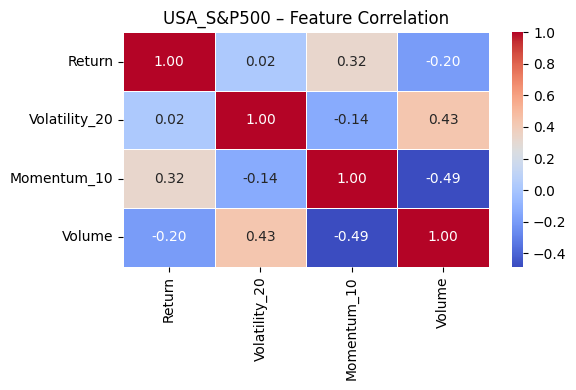

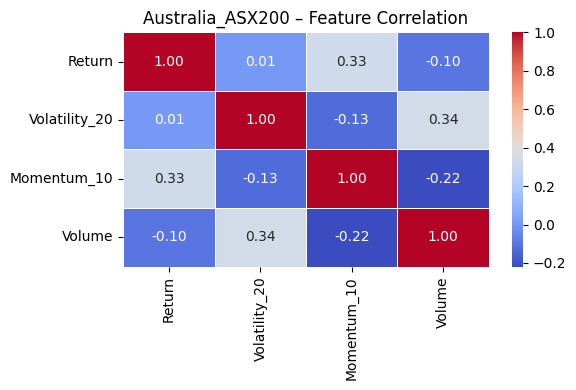

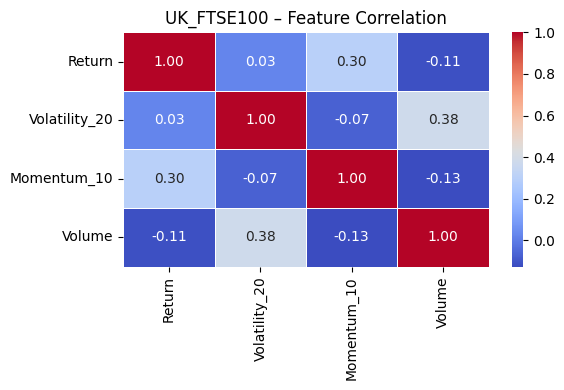

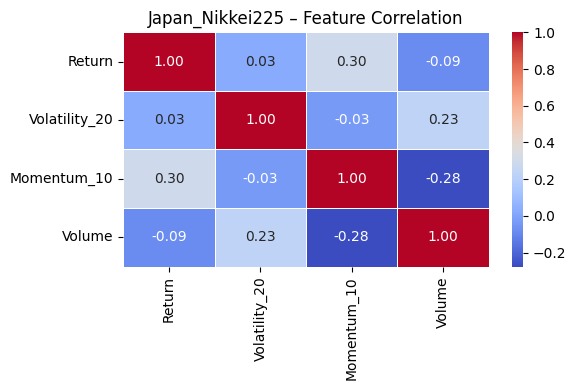

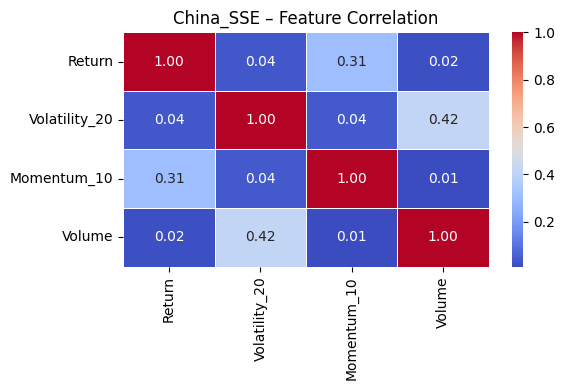

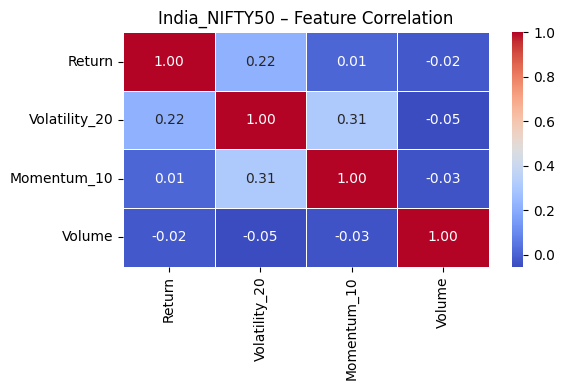

In [26]:
print("\n" + "=" * 80)
print("FEATURE CORRELATION")

features = ["Return", "Volatility_20", "Momentum_10", "Volume"]

for market, df in clean_market_data.items():

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        df[features].corr(),
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5
    )

    plt.title(f"{market} – Feature Correlation")
    plt.tight_layout()
    plt.show()

Drawdown Analysis (Risk Insight)

In [27]:
print("\n" + "=" * 80)
print("DRAWDOWN ANALYSIS")

for market, df in clean_market_data.items():

    cumulative = (1 + df["Return"]).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max

    fig = px.line(
        x=df["Date"],
        y=drawdown,
        title=f"{market} – Drawdown Analysis",
        template="plotly_white"
    )

    fig.update_traces(line=dict(width=2.5))
    fig.update_yaxes(title="Drawdown")
    fig.update_xaxes(rangeslider_visible=True)

    fig.show()


DRAWDOWN ANALYSIS


In [19]:
train_data = {}
test_data = {}

split_date = "2022-01-01"

for market, df in clean_market_data.items():

    train_df = df[df["Date"] < split_date].reset_index(drop=True)
    test_df  = df[df["Date"] >= split_date].reset_index(drop=True)

    train_data[market] = train_df
    test_data[market] = test_df

    print(f"\n{market}")
    print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")

# --------------------------------------------------
# Preview final output (example market)
# --------------------------------------------------
example_market = "USA_S&P500"

print("\nFinal dataset preview:", example_market)
print(clean_market_data[example_market].head(10))


USA_S&P500
Train rows: 1743 | Test rows: 1027

Australia_ASX200
Train rows: 1755 | Test rows: 1033

UK_FTSE100
Train rows: 1751 | Test rows: 1032

Japan_Nikkei225
Train rows: 1743 | Test rows: 1027

China_SSE
Train rows: 1743 | Test rows: 1027

India_NIFTY50
Train rows: 1709 | Test rows: 1012

Final dataset preview: USA_S&P500
        Date        Open        High         Low       Close     Volume  \
0 2015-02-02  200.050003  202.029999  197.860001  201.919998  163107000   
1 2015-02-03  203.000000  204.850006  202.550003  204.839996  124212900   
2 2015-02-04  203.919998  205.380005  203.509995  204.059998  134306700   
3 2015-02-05  204.860001  206.300003  204.770004  206.119995   97953200   
4 2015-02-06  206.559998  207.240005  204.919998  205.550003  125672000   
5 2015-02-09  204.770004  205.639999  204.139999  204.630005   87219000   
6 2015-02-10  205.880005  207.119995  204.679993  206.809998   96164200   
7 2015-02-11  206.610001  207.449997  205.830002  206.929993   9108780

In [20]:
for market, df in clean_market_data.items():
    print("\n" + "="*50)
    print(f"Market: {market}")
    print(df.describe())


Market: USA_S&P500
                                Date         Open         High          Low  \
count                           2770  2770.000000  2770.000000  2770.000000   
mean   2020-08-01 11:55:19.277978368   364.724281   366.682823   362.580289   
min              2015-02-02 00:00:00   182.339996   184.100006   181.020004   
25%              2017-10-30 06:00:00   250.444996   254.684994   249.462498   
50%              2020-08-01 12:00:00   331.900009   333.774994   330.835007   
75%              2023-05-02 18:00:00   446.257492   448.397499   443.664993   
max              2026-02-05 00:00:00   697.049988   697.840027   693.940002   
std                              NaN   134.833616   135.441130   134.102497   

             Close        Volume       Return  Volatility_20  Momentum_10  
count  2770.000000  2.770000e+03  2770.000000    2770.000000  2770.000000  
mean    364.785379  8.553169e+07     0.000571       0.009357     0.005611  
min     182.860001  2.027000e+07    -0.1

In [28]:
for market, df in train_data.items():
    df["Volume_MA20"] = df["Volume"].rolling(20).mean()
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

## **Environment Code**

In [29]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

In [30]:
class TradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, df, risk_penalty=0.001):
        super().__init__()

        self.df = df.reset_index(drop=True)
        self.risk_penalty = risk_penalty

        # Actions: Hold, Buy, Sell
        self.action_space = spaces.Discrete(3)

        # Observation: [Return, Volatility, Momentum, Volume_norm, Position]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.step_idx = 0
        self.position = 0  # -1 short, 0 flat, +1 long
        self.portfolio_value = 1.0
        self.prev_price = self.df.loc[self.step_idx, "Close"]

        return self._get_observation(), {}

    def _get_observation(self):
        row = self.df.loc[self.step_idx]

        volume_norm = row["Volume"] / row["Volume_MA20"]

        return np.array([
            row["Return"],
            row["Volatility_20"],
            row["Momentum_10"],
            volume_norm,
            self.position
        ], dtype=np.float32)

    def step(self, action):
        current_price = self.df.loc[self.step_idx, "Close"]

        if action == 1:
            self.position = 1
        elif action == 2:
            self.position = -1

        price_change = (current_price - self.prev_price) / self.prev_price
        portfolio_return = self.position * price_change

        volatility = self.df.loc[self.step_idx, "Volatility_20"]
        reward = 100 * portfolio_return - 10 * self.risk_penalty * volatility

        self.portfolio_value *= (1 + portfolio_return)

        self.prev_price = current_price
        self.step_idx += 1

        done = self.step_idx >= len(self.df) - 1
        obs = self._get_observation() if not done else np.zeros(5)

        info = {"portfolio_value": self.portfolio_value}

        return obs, reward, done, False, info

    def render(self):
        print(
            f"Step {self.step_idx} | "
            f"Position {self.position} | "
            f"Portfolio {self.portfolio_value:.3f}"
        )

### **Train PPO (single market)**

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

env = DummyVecEnv([
    lambda: TradingEnv(train_data["USA_S&P500"])
])

model = PPO(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    gamma=0.99,
    verbose=1
)

model.learn(total_timesteps=200_000)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



-----------------------------
| time/              |      |
|    fps             | 1003 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



------------------------------------------
| time/                   |              |
|    fps                  | 651          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0074061807 |
|    clip_fraction        | 0.0587       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | -0.0133      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.52         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00544     |
|    value_loss           | 16.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 555         |
|    iterations           | 3           |
|    time_elapsed         | 11          |
|    total_times